# Compare likelihoods 

Debugging the relative binning likelihood and the problem of weird peaking of the Mc likelihood values

Also see the .py script, which came first

## Preamble

### Imports and jim prior setup

In [1]:
import psutil
p = psutil.Process()
p.cpu_affinity([0])

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from tqdm import tqdm
import json
import numpy as np

import jax
print(jax.devices())
import jax.numpy as jnp
from jimgw.prior import Uniform, Composite
import matplotlib.pyplot as plt
import pickle

from save_likelihoods import NAMING as naming 
from save_likelihoods import PRIOR

prior_ranges = jnp.array([PRIOR[name] for name in naming])
prior_low, prior_high = prior_ranges[:, 0], prior_ranges[:, 1]

N_samples = 50

2024-02-26 06:59:20.005344: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0)]


In [2]:
# Priors without transformation
Mc_prior = Uniform(prior_low[0], prior_high[0], naming=['M_c'])
q_prior = Uniform(prior_low[1], prior_high[1], naming=['q'],
                    transforms={
    'q': (
        'eta',
        lambda params: params['q'] /
        (1 + params['q']) ** 2
    )
}
)
s1z_prior = Uniform(prior_low[2], prior_high[2], naming=['s1_z'])
s2z_prior = Uniform(prior_low[3], prior_high[3], naming=['s2_z'])
lambda_1_prior = Uniform(prior_low[4], prior_high[4], naming=['lambda_1'])
lambda_2_prior = Uniform(prior_low[5], prior_high[5], naming=['lambda_2'])
dL_prior = Uniform(prior_low[6], prior_high[6], naming=['d_L'])
tc_prior = Uniform(prior_low[7], prior_high[7], naming=['t_c'])
phic_prior = Uniform(prior_low[8], prior_high[8], naming=['phase_c'])
cos_iota_prior = Uniform(prior_low[9], prior_high[9], naming=["cos_iota"],
                            transforms={
    "cos_iota": (
        "iota",
        lambda params: jnp.arccos(
            jnp.arcsin(
                jnp.sin(params["cos_iota"] / 2 * jnp.pi)) * 2 / jnp.pi
        ),
    )
},
)
psi_prior = Uniform(prior_low[10], prior_high[10], naming=["psi"])
ra_prior = Uniform(prior_low[11], prior_high[11], naming=["ra"])
sin_dec_prior = Uniform(prior_low[12], prior_high[12], naming=["sin_dec"],
                        transforms={
    "sin_dec": (
        "dec",
        lambda params: jnp.arcsin(
            jnp.arcsin(
                jnp.sin(params["sin_dec"] / 2 * jnp.pi)) * 2 / jnp.pi
        ),
    )
},
)

# Compose the prior
prior_list = [
    Mc_prior,
    q_prior,
    s1z_prior,
    s2z_prior,
    lambda_1_prior,
    lambda_2_prior,
    dL_prior,
    tc_prior,
    phic_prior,
    cos_iota_prior, # 9
    psi_prior, # 10
    ra_prior, # 11
    sin_dec_prior, # 12
]
complete_prior = Composite(prior_list)
bounds = jnp.array([[p.xmin, p.xmax] for p in complete_prior.priors])
print("Finished prior setup")

Finished prior setup


In [3]:
jim_path = './outdir/injection_14/likelihood.pkl'
bilby_path = "/home/narola.bharatbhai/jim_bilby_crosscheck/jim/bilby_runs/injection_14/update_theta_jn_injection_14_result.json" # on CIT!

### Load jim data

In [4]:
# Load config.json
with open(f'./outdir/injection_14/config.json', 'r') as f:
    config = json.load(f)
    
true_params_np = np.array([config[p] for p in naming])
true_mc = true_params_np[0]

# Convert cos_iota to iota, sin_dec to dec
true_params_np[9] = jnp.arccos(true_params_np[9])
true_params_np[12] = jnp.arcsin(true_params_np[12])

# Load jim chains

jim_data = np.load(f'./outdir/injection_14/results_production.npz')
jim_chains, jim_log_prob = jim_data["chains"], jim_data["log_prob"]

jim_chains = np.array(jim_chains)
jim_chains = np.reshape(jim_chains, (-1, 13))

jim_log_prob = np.reshape(jim_log_prob, (-1,))

# Thin the samples a bit
jump = 100
jim_chains = jim_chains[::jump]
jim_log_prob = jim_log_prob[::jump]

In [19]:
# Load likelihood with pickle
with open(jim_path, 'rb') as f:
    my_likelihood = pickle.load(f)

### Load bilby data

In [6]:
# Load the bilby data 
print("Loading bilby data")
with open(bilby_path, "r") as f:
    bilby_data = json.load(f)
bilby_posterior = bilby_data["posterior"]["content"]

bilby_naming = ['chirp_mass',
          'mass_ratio',
          'chi_1',
          'chi_2',
          'lambda_1',
          'lambda_2',
          'luminosity_distance',
          'geocent_time',
          'phase',
          'theta_jn',
          'psi',
          'ra',
          'dec'] # note we also have: # 'log_likelihood', 'log_prior'

bilby_chains = np.array([bilby_posterior[name] for name in bilby_naming])
bilby_chains = bilby_chains.T

print(np.shape(bilby_chains))

Loading bilby data
(12189, 13)


## Comparing bilby output to jim likelihood

### jim likelihood

In [7]:
prior_params = complete_prior.add_name(jim_chains.T)
jim_prior_prob = complete_prior.log_prob(prior_params)

print("np.mean(jim_prior_prob)")
print(np.mean(jim_prior_prob))

jim_log_likelihood = jim_log_prob - jim_prior_prob

print(np.shape(jim_log_likelihood))

mc_jim = jim_chains[:, 0]

np.mean(jim_prior_prob)
-22.479974306343397
(7500,)


### bilby likelihood

In [8]:
bilby_log_likelihood = np.array(bilby_posterior['log_likelihood'])
bilby_log_prior = np.array(bilby_posterior['log_prior'])
log_prob = bilby_log_likelihood + bilby_log_prior

### Comparison

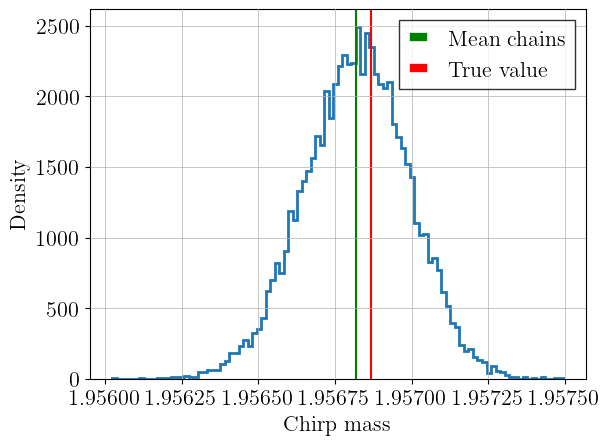

In [9]:
np.shape(bilby_chains)
mc_bilby = bilby_chains[:, 0]
plt.hist(mc_bilby, bins=100, histtype='step', density=True, linewidth=2)
plt.axvline(np.mean(mc_bilby), color='green', label = 'Mean chains')
plt.axvline(true_mc, color='red', label = 'True value')
plt.legend()
plt.xlabel('Chirp mass')
plt.ylabel('Density')
plt.show()

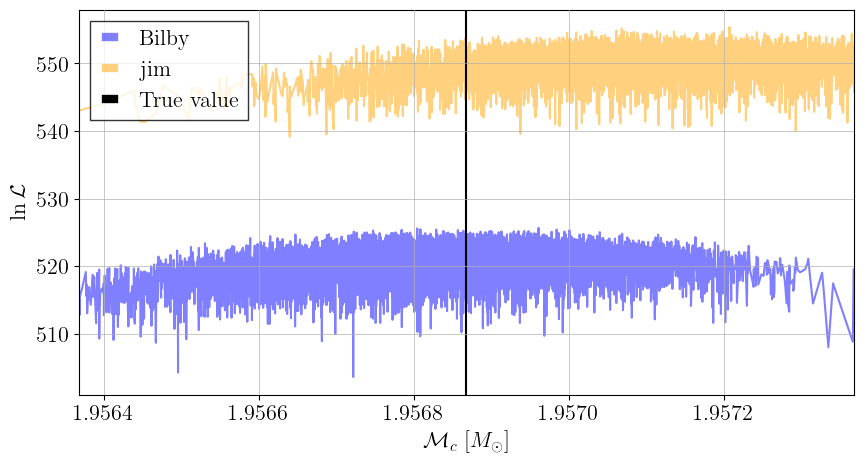

In [10]:
alpha = 0.5
# Argsort the the Mc and sort likelihood as well there
argsort = np.argsort(mc_bilby)
mc_bilby_sorted = mc_bilby[argsort]
bilby_log_likelihood_sorted = bilby_log_likelihood[argsort]

argsort = np.argsort(mc_jim)
mc_jim_sorted = mc_jim[argsort]
jim_log_likelihood_sorted = jim_log_likelihood[argsort]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(mc_bilby_sorted, bilby_log_likelihood_sorted, color = "blue", label = "Bilby", alpha = alpha)
plt.plot(mc_jim_sorted, jim_log_likelihood_sorted, color = "orange", label = "jim", alpha = alpha)
plt.axvline(true_mc, color='black', label = 'True value')
# Limit
mc_std = 0.0005
mc_left = true_mc - mc_std
mc_right = true_mc + mc_std
plt.xlim(mc_left, mc_right)
plt.xlabel(r'$\mathcal{M}_c \ [M_\odot]$')
plt.ylabel(r'$\ln \mathcal{L}$')
plt.legend()
plt.show()

## Compare against true likelihood values

In [13]:
def my_compute_likelihood(params):
    """
    Note: must take arccos for jim chains, but not the case for true params (gives NaNs otherwise)
    """
    my_params_named = complete_prior.add_name(params)

    # Convert cos_iota to iota, sin_dec to dec, q to eta
    my_params_named["iota"] = jnp.arccos(my_params_named["cos_iota"])
    my_params_named["dec"] = jnp.arcsin(my_params_named["sin_dec"])
    q = my_params_named["q"]
    my_params_named["eta"] = q / (1 + q) ** 2
    
    # value = my_likelihood.evaluate(my_params_named, {})
    value = my_likelihood.evaluate_original(my_params_named, {})
    
    return value

my_compute_likelihood_jit = jax.jit(my_compute_likelihood)

# Iterate over the jim chains and compute them OR NOTE that we can load them just below here
# my_log_likelihoods = []

# for i in tqdm(range(len(jim_chains))):
#     my_log_likelihoods.append(my_compute_likelihood_jit(jim_chains[i]))
    
# my_log_likelihoods = np.array(my_log_likelihoods)

# np.savez("./outdir/injection_14/log_likelihoods_original.npz", log_likelihoods_original = my_log_likelihoods)

### Load in again
data = np.load(f'./outdir/injection_14/log_likelihoods_original.npz')
my_log_likelihoods = data["log_likelihoods_original"]

  0%|          | 0/7500 [00:00<?, ?it/s]

100%|██████████| 7500/7500 [09:33<00:00, 13.09it/s]


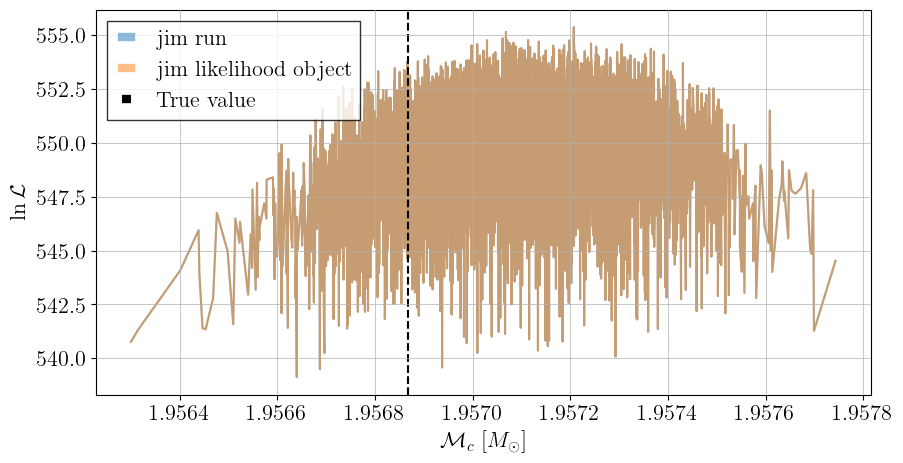

In [15]:
alpha = 0.5

plt.figure(figsize=(10, 5))

names_list = ["jim run", "jim likelihood object"]
mc_list = [mc_jim, mc_jim]
log_likelihood_list = [jim_log_likelihood, my_log_likelihoods]

for (name, mc_values, log_likelihood_values) in zip(names_list, mc_list, log_likelihood_list):
    argsort = np.argsort(mc_values)
    mc_values_sorted = mc_values[argsort]
    log_likelihood_values_sorted = log_likelihood_values[argsort]
    plt.plot(mc_values_sorted, log_likelihood_values_sorted, label = name, alpha = alpha)


# Plot some extra stuff as well
plt.axvline(true_mc, color='black', linestyle = "--", label = 'True value')
# Limit
# mc_std = 0.0005
# mc_left = true_mc - mc_std
# plt.xlim(true_mc - mc_std, true_mc + mc_std)
plt.xlabel(r'$\mathcal{M}_c \ [M_\odot]$')
plt.ylabel(r'$\ln \mathcal{L}$')
plt.legend()
plt.show()

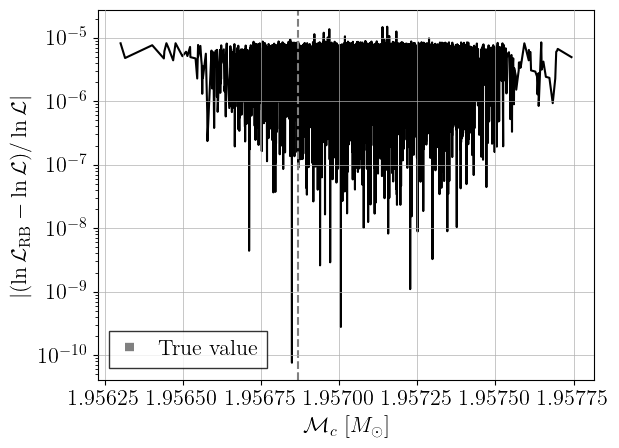

In [16]:
diffs = abs((jim_log_likelihood - my_log_likelihoods) / my_log_likelihoods)
plt.plot(mc_values_sorted, diffs, color = "black")

# Plot some extra stuff as well
plt.axvline(true_mc, color='grey', linestyle = "--", label = 'True value')
# Limit
# mc_std = 0.0005
# mc_left = true_mc - mc_std
# plt.xlim(true_mc - mc_std, true_mc + mc_std)
plt.xlabel(r'$\mathcal{M}_c \ [M_\odot]$')
plt.ylabel(r'$|(\ln \mathcal{L}_{\rm RB} - \ln \mathcal{L}) / \ln \mathcal{L}|$')
plt.yscale('log')
plt.legend()
plt.show()

## Now with maximization

In [20]:
def my_compute_likelihood(params):
    """
    Note: must take arccos for jim chains, but not the case for true params (gives NaNs otherwise)
    """
    my_params_named = complete_prior.add_name(params)

    # Convert cos_iota to iota, sin_dec to dec, q to eta
    my_params_named["iota"] = jnp.arccos(my_params_named["cos_iota"])
    my_params_named["dec"] = jnp.arcsin(my_params_named["sin_dec"])
    q = my_params_named["q"]
    my_params_named["eta"] = q / (1 + q) ** 2
    
    # value = my_likelihood.evaluate(my_params_named, {})
    value = my_likelihood.my_evaluate(my_params_named, {})
    
    return value

my_compute_likelihood_jit = jax.jit(my_compute_likelihood) 

# # Iterate over the jim chains and compute them OR NOTE that we can load them just below here
# my_log_likelihoods = []

# for i in tqdm(range(len(jim_chains))):
#     my_log_likelihoods.append(my_compute_likelihood_jit(jim_chains[i]))
    
# my_log_likelihoods = np.array(my_log_likelihoods)

100%|██████████| 7500/7500 [23:00<00:00,  5.43it/s]


In [21]:
# np.savez("./outdir/injection_14/log_likelihoods_maximized.npz", log_likelihoods_maximized = my_log_likelihoods)

In [ ]:
### Load in again
data = np.load(f'./outdir/injection_14/log_likelihoods_maximized.npz')
my_log_likelihoods = data["log_likelihoods_maximized"]

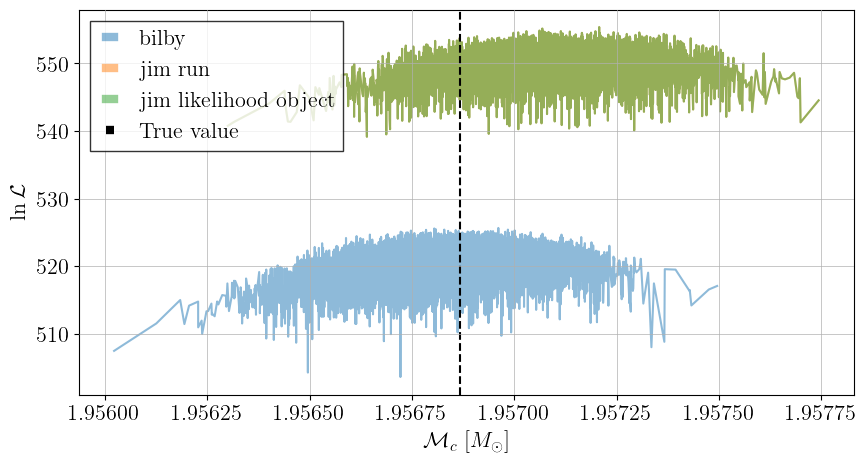

In [22]:
alpha = 0.5

plt.figure(figsize=(10, 5))

names_list = ["bilby", "jim run", "jim likelihood object"]
mc_list = [mc_bilby, mc_jim, mc_jim]
log_likelihood_list = [bilby_log_likelihood, jim_log_likelihood, my_log_likelihoods]

for (name, mc_values, log_likelihood_values) in zip(names_list, mc_list, log_likelihood_list):
    argsort = np.argsort(mc_values)
    mc_values_sorted = mc_values[argsort]
    log_likelihood_values_sorted = log_likelihood_values[argsort]
    plt.plot(mc_values_sorted, log_likelihood_values_sorted, label = name, alpha = alpha)


# Plot some extra stuff as well
plt.axvline(true_mc, color='black', linestyle = "--", label = 'True value')
# Limit
# mc_std = 0.0005
# mc_left = true_mc - mc_std
# plt.xlim(true_mc - mc_std, true_mc + mc_std)
plt.xlabel(r'$\mathcal{M}_c \ [M_\odot]$')
plt.ylabel(r'$\ln \mathcal{L}$')
plt.legend()
plt.show()

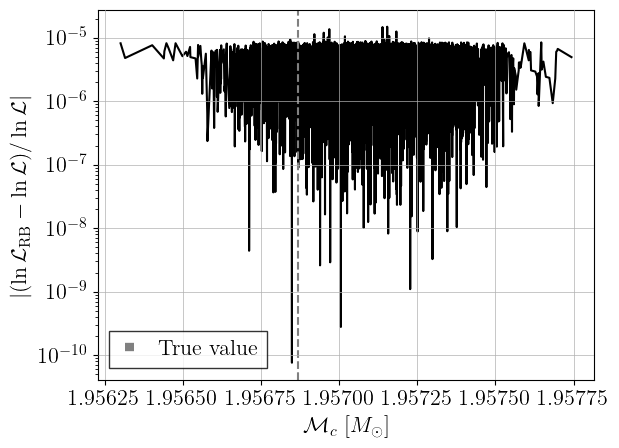

In [23]:
diffs = abs((jim_log_likelihood - my_log_likelihoods) / my_log_likelihoods)
plt.plot(mc_values_sorted, diffs, color = "black")

# Plot some extra stuff as well
plt.axvline(true_mc, color='grey', linestyle = "--", label = 'True value')
# Limit
# mc_std = 0.0005
# mc_left = true_mc - mc_std
# plt.xlim(true_mc - mc_std, true_mc + mc_std)
plt.xlabel(r'$\mathcal{M}_c \ [M_\odot]$')
plt.ylabel(r'$|(\ln \mathcal{L}_{\rm RB} - \ln \mathcal{L}) / \ln \mathcal{L}|$')
plt.yscale('log')
plt.legend()
plt.show()

# Archive

Computing log likelihood on an array of Mc close to the true Mc

In [18]:
# # # Evaluate the likelihood object also separately at the true parameters
# # N_samples = 50
# # mc_values = np.linspace(mc_left, mc_right, N_samples)

# # my_params = np.vstack(N_samples * [true_params_np])
# # print(np.shape(my_params))

# # my_params[:, 0] = mc_values
# # my_params = jnp.array(my_params)

# # my_params_stacked = jnp.array(my_params).T
# # my_params_stacked_named = complete_prior.add_name(my_params_stacked)

# # # Convert cos_iota to iota, sin_dec to dec, and q to eta
# # my_params_stacked_named["iota"] = my_params_stacked_named["cos_iota"]
# # my_params_stacked_named["dec"] = my_params_stacked_named["sin_dec"]
# # q = my_params_stacked_named["q"]
# # my_params_stacked_named["eta"] = q / (1 + q)**2

# # likelihood_evaluate_vmap = jax.vmap(my_likelihood.evaluate, in_axes=(0, None))
# # likelihood_evaluate_original_vmap = jax.vmap(my_likelihood.evaluate_original, in_axes=(0, None))

# # my_log_likelihoods = likelihood_evaluate_original_vmap(my_params_stacked_named, {})

# # Evaluate the likelihood object also separately at the true parameters
# N_samples = 50
# mc_values = np.linspace(mc_left, mc_right, N_samples)

# my_params = np.vstack(N_samples * [true_params_np])
# print(np.shape(my_params))

# my_params[:, 0] = mc_values
# my_params = jnp.array(my_params)

# ### Evaluate the likelihood at these:
# my_log_likelihoods = []
# for param in tqdm(my_params):
    
#     my_log_likelihoods.append(value)

# my_log_likelihood = np.array(my_log_likelihoods)
# print(np.shape(my_log_likelihood))

(50, 13)


  0%|          | 0/50 [00:00<?, ?it/s]


NameError: name 'value' is not defined

In [ ]:
# tc_values_jim = jim_chains[:, 7]
# tc_values_bilby = bilby_chains[:, 7] - 1187008882.43

# timeshift = np.mean(tc_values_bilby) - np.mean(tc_values_jim)
# print(np.mean(tc_values_jim) + timeshift)